# Final Project
#### Advanced Data Analytics and Applications

Team 4


Last revision: 11/18/2022

**Update:**

- 11/14: Priminary models are built and embedding with Word2Vec.
- 11/15: tunning building training process
- 11/17: Building the models.
- 11/18: training on testing set

**Domain 2: Medical Text Domain**
Using a medical text library split into training and test, perform the following activities:

**Checklist:**

1. Verify the 5 categories as described in the dataset are applicable
2. Build a robust multi-category classifier to predict the 5 categories based on the training dataset (Naive-Bayes, Neural Networks, ML, Fasttext)

3. Evaluate performance on the test dataset

4. Do one of the following:
  1. Build a language model on the dataset using Fasttext or Word2Vec
  2. Use BM25 indexing to make the abstracts searchable
  3. Use topic modeling to identify themes beyond the 5 classes.
  4. Use spaCy to create an inventory of Named Entities for each abstract and  then use those to create a multi-label classifier





In [3]:
import sys
sys.path.append('./source/utils')
import utils
from utils import (
    preprocess,
    eval_auc,
    eval_model,
    evaluate_features,
    sanity_check,
    MeanEmbeddingVectorizer
    )


In [4]:
import spacy
import pandas as pd
import numpy as np
import sklearn
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer 
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import preprocess_string
#from gensim.summarization.bm25 import BM25
from rank_bm25 import BM25
from gensim.models.fasttext import FastText
import gensim.downloader as api

from pprint import pprint

from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold, GridSearchCV, cross_validate
from sklearn.metrics import log_loss, accuracy_score, classification_report, f1_score, roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.pipeline import make_pipeline,Pipeline

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt
import os

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

import keras

from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing.text import Tokenizer
#from keras import pad_sequences
from keras.models import Sequential, Model 
from keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten, Dropout, Input, Embedding, Concatenate
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.optimizers import Adam
from keras import layers

from IPython.display import display, Markdown, HTML


nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')

nlp = spacy.load('en_core_web_md')

C:\Users\cpw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\cpw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.13) or chardet (5.1.0)/charset_normalizer (2.0.8) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cpw\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\cpw\AppData\Roaming\nltk_data...
[nltk_data]   Pa

#Task 1 Verify Labels
1.1 Verify the 5 categories as described in the dataset are applicable

Proposed Labels - unverified
1. neoplasm
2. digestive
3. nervous system
4. cardiovascular
5. general

## Download & Store data

In [5]:
#Seperation of labels and text data
labels = []
texts = []
with open("data/train.dat", "r") as f:
     train_data = f.readlines() 

for line in train_data:
    splitline = line.split('\t')
    labels.append(splitline[0])
    texts.append(splitline[1])

f.close()
train_df = pd.DataFrame(   data = {'label': labels,
                                    'desc': texts   })

In [291]:
#Find desc with multiple-label
train_df['multi-label'] = 0
train_df.loc[train_df.duplicated('desc',keep=False),'multi-label'] = 1
train_df['multi-label'].value_counts()

#6140 rows with more than 1 label

0    8298
1    6140
Name: multi-label, dtype: int64

2    2653
3     270
4       6
1    6140
Name: number, dtype: int64

In [304]:
duplicate = train_df[train_df['multi-label']==1]
duplicate = duplicate.groupby(duplicate.desc.tolist()).size().reset_index().rename(columns={0:'number'})
duplicated_distribution = duplicate['number'].value_counts()
duplicated_distribution[1] = len(train_df[train_df['multi-label']==0])
duplicated_distribution.sort_index()

# 2653 row has 2 labels
# 270 rows has 3 labels
# 6 rows has 4 labels

1    8298
2    2653
3     270
4       6
Name: number, dtype: int64

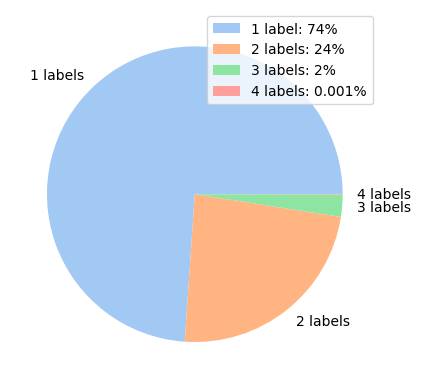

In [320]:
colors = sns.color_palette('pastel')[0:4]

labels = ['1 label: 74%','2 labels: 24%','3 labels: 2%', '4 labels: 0.001%']

plt.pie(x=duplicated_distribution.sort_index(), 
        labels = [f'{i} labels' for i in range(1,5)], 
        colors = colors)

plt.legend(labels)


In [293]:
# Identify unique desciption
train_df['unique'] = 0
train_df.loc[ (train_df.duplicated('desc')==False),'unique']= 1
train_df['unique'].sum()

11227

In [9]:
#Raise some examples: 
msg = duplicate.iloc[49]['index']

for i in train_df[train_df['desc']==msg].index:
  print('Index:', str(i))
  print('label:', train_df['label'][i])
  print(train_df['desc'][i][:300])
  print('\n')
    


Index: 10057
label: 2
A pilot study of suramin in the treatment of metastatic renal cell carcinoma. Suramin sodium is an aromatic polysulfonated compound that was originally introduced as an antiparasitic agent in the 1920s. Recently, in view of its ability to bind and disrupt the function of multiple growth factors and 


Index: 10120
label: 1
A pilot study of suramin in the treatment of metastatic renal cell carcinoma. Suramin sodium is an aromatic polysulfonated compound that was originally introduced as an antiparasitic agent in the 1920s. Recently, in view of its ability to bind and disrupt the function of multiple growth factors and 


Index: 12075
label: 3
A pilot study of suramin in the treatment of metastatic renal cell carcinoma. Suramin sodium is an aromatic polysulfonated compound that was originally introduced as an antiparasitic agent in the 1920s. Recently, in view of its ability to bind and disrupt the function of multiple growth factors and 


Index: 13327
label: 5
A p

In [10]:
#Prepare for mult-label classificaiton dataframe 

multi_df = train_df.copy()
multi_df['label'] = multi_df['label'].astype(int)-1

for i in range(0,5):
  multi_df[str(i)] = [1 if x == i else 0 for x in multi_df['label'] ]

multi_df = multi_df.groupby('desc').sum().reset_index().drop(['label','multi-label','unique'],axis=1)

multi_df.head(5)  #noted that the 5th row has both label 0 and 2

,desc,0,1,2,3,4
0,"""Cloggology"" revisited: endoscopic or surgical...",0,0,0,0,1
1,"""Frontal lobe"" utilization behavior associated...",0,0,1,0,0
2,"""Healed"" experimental gastric ulcers remain hi...",0,1,0,0,0
3,"""Mini-perforation"" of the colon--not all postp...",0,1,0,0,0
4,"""Moustache"" appearance in craniopharyngiomas: ...",1,0,1,0,0


## Start with Multi-category Classification Process

In [11]:
#preprocess all label 1-5 > 0-4
train_df['label'] = train_df['label'].astype(int)-1


In [12]:
train_df['label'].value_counts().sort_index()
#_ imbalance dataset


0    3163
1    1494
2    1925
3    3051
4    4805
Name: label, dtype: int64

In [13]:
dz_dict = {
  0 : 'Oncology',
  1 : 'Gastroenterology',
  2 : 'Neural disease',
  3 : 'Cardiovascular',
  4 : 'General'}

train_df['label_desc'] =train_df['label'].map(dz_dict)

<AxesSubplot: xlabel='label_desc', ylabel='count'>

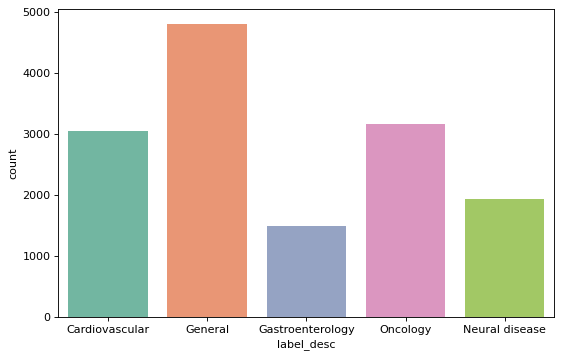

In [14]:
#distribution
plt.figure(figsize=(8, 5), dpi=80)
sns.countplot(x = train_df['label_desc'] ,palette='Set2')

In [15]:
#Step 1. manual review samples

for i in sorted(train_df['label'].unique()):
  print(f'Class: ' + train_df[train_df['label']==i].head(1)['label_desc'].values)
  pprint(str(i) + ' : ' + train_df[train_df['label']==i].iloc[:3]['desc'].values, width=200, compact = True)
  
# 1:  2/3 correct (1 general)
# 2:  3/3 correct
# 3:  3/3 correct
# 4:  3/3 correct
# 5:  1/3 correct (1 cardiovascular, 1 neoplasm)

# As we can see, the label of class 5 (general) is very unreliable

['Class: Oncology']
array(['0 : Infection during chronic epidural catheterization: diagnosis and treatment. A potentially serious complication of long-term epidural catheterization in cancer patients is infection. The early signs of infection were studied in 350 patients in whom long-term epidural catheters were inserted. Three areas of the catheter track were found to be involved; exit site and superficial catheter track infection, and epidural space infection. The authors identified the early signs of infection in each area and the progress of the infection from the deep track to include the epidural space in four of these patients. All 19 patients who developed deep track or epidural infections were successfully treated with antibiotics and catheter removal. None of the patients required surgery for spinal cord decompression. Catheters were replaced in 15 of the 19 treated patients who requested them after treatment with no recurrent infections. It was concluded that use of long-ter

In [16]:
#Sanity check again for group 5 

for i in range(0,8):
  pprint(str(i)+ ' : ' + train_df[train_df['label']==4].iloc[i]['desc'][:500], width=100, compact=True)


# 1- Renal abscess in children - ID / General
# 2- Subclavian artery to innominate vein fistula - Cardiovascular [Wrong Label]
# 3- Mediastinal tracheostomy for esophageal cancer - Cancer [Wrong Label]
# 4- idiopathic fibroinflammatory - Derm / General
# 5- asthma  - Pulm / General
# 6- automatic implantable cardioverter defibrillator - cardiovascuar [Wrong label]
# 7- stress-related mucosal damage - GI [Wrong Label]
# 8- HSV  - ID / General 

# 4/8  ~ 50% with incorrect label 

('0 : Renal abscess in children. Three cases of renal abscesses in children are described to '
 'illustrate the variable presenting features. An additional 23 pediatric cases, reported over the '
 'past ten years, were reviewed for clinical features and therapy. Fever, loin pain, and '
 'leukocytosis were common presenting features, but less than half of all abscesses were '
 'associated with either an abnormal urinalysis or a positive urine culture. The presenting '
 'features were sometimes confused with appendicitis, ')
('1 : Subclavian artery to innominate vein fistula after insertion of a hemodialysis catheter. '
 'Insertion of hemodialysis catheters for temporary use is now preferentially performed by '
 'percutaneous infraclavicular subclavian vein catheterization. This method involves passage of a '
 'stiff dilator and a peel-away sheath over a guide wire, and is usually carried out without '
 'fluoroscopy. For the most part this has proved to be a valuable and safe approach. H

## Pre-Process

In [17]:
# https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794
# Classification

In [18]:
train_df['token'] = train_df['desc'].apply(lambda x: preprocess(x))
train_df['clean'] = [' '.join(x) for x in train_df['token']]
train_df.head()

,label,desc,multi-label,unique,label_desc,token,clean
0,3,Catheterization laboratory events and hospital...,1,1,Cardiovascular,"[catheterization, laboratory, event, hospital,...",catheterization laboratory event hospital outc...
1,4,Renal abscess in children. Three cases of rena...,0,1,General,"[renal, abscess, child, three, case, renal, ab...",renal abscess child three case renal abscess c...
2,1,Hyperplastic polyps seen at sigmoidoscopy are ...,1,1,Gastroenterology,"[hyperplastic, polyp, seen, sigmoidoscopy, mar...",hyperplastic polyp seen sigmoidoscopy marker a...
3,4,Subclavian artery to innominate vein fistula a...,0,1,General,"[subclavian, artery, innominate, vein, fistula...",subclavian artery innominate vein fistula inse...
4,3,Effect of local inhibition of gamma-aminobutyr...,1,1,Cardiovascular,"[effect, local, inhibition, gamma-aminobutyric...",effect local inhibition gamma-aminobutyric aci...


In [19]:
multi_df['token'] = multi_df['desc'].apply(lambda x: preprocess(x))
multi_df['clean'] = [' '.join(x) for x in multi_df['token']]

multi_df.head()

,desc,0,1,2,3,4,token,clean
0,"""Cloggology"" revisited: endoscopic or surgical...",0,0,0,0,1,"[cloggology, revisited, endoscopic, surgical, ...",cloggology revisited endoscopic surgical decom...
1,"""Frontal lobe"" utilization behavior associated...",0,0,1,0,0,"[frontal, lobe, utilization, behavior, associa...",frontal lobe utilization behavior associated p...
2,"""Healed"" experimental gastric ulcers remain hi...",0,1,0,0,0,"[healed, experimental, gastric, ulcer, remain,...",healed experimental gastric ulcer remain histo...
3,"""Mini-perforation"" of the colon--not all postp...",0,1,0,0,0,"[mini-perforation, colon, postpolypectomy, per...",mini-perforation colon postpolypectomy perfora...
4,"""Moustache"" appearance in craniopharyngiomas: ...",1,0,1,0,0,"[moustache, appearance, craniopharyngiomas, un...",moustache appearance craniopharyngiomas unique...


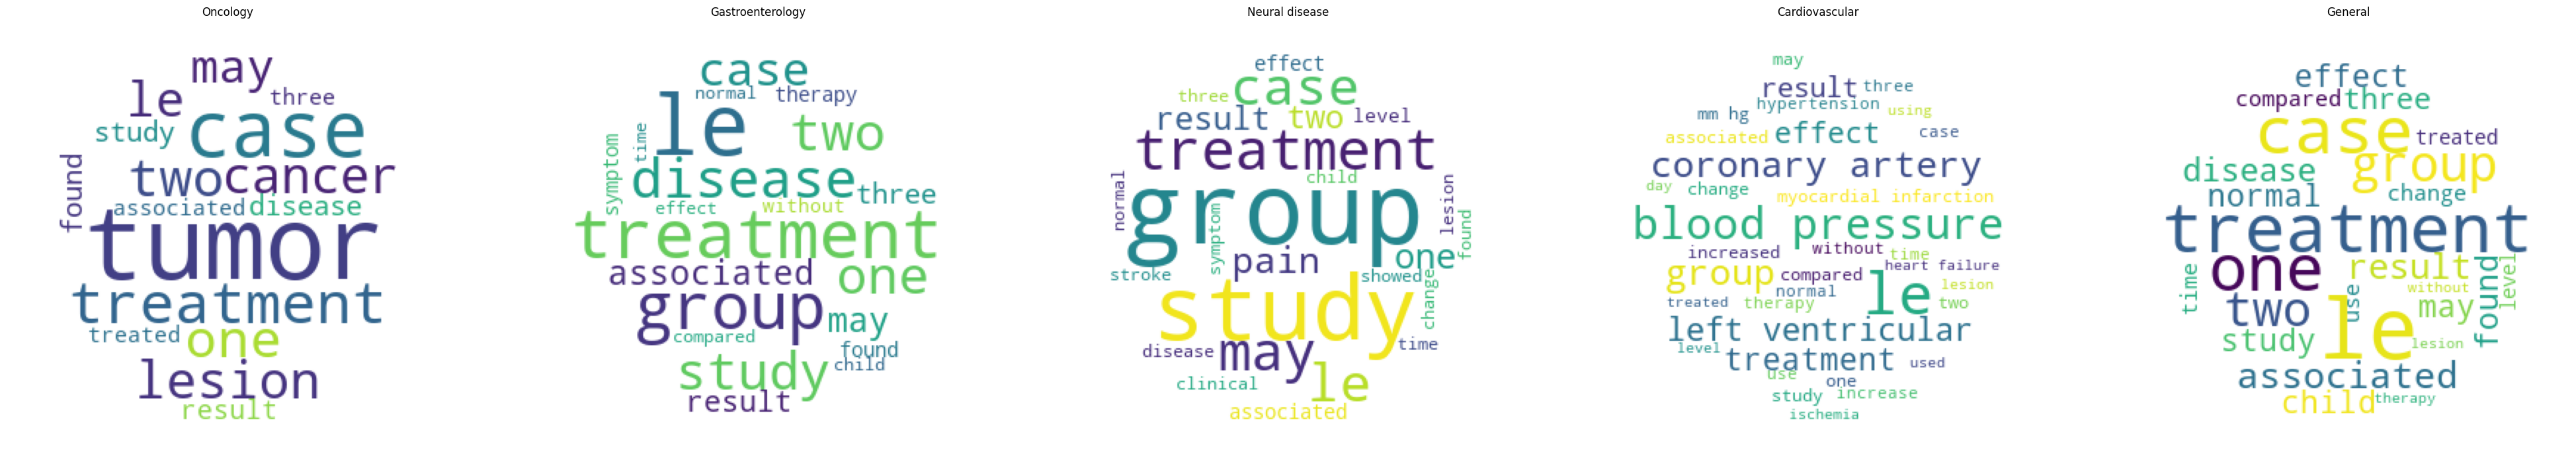

In [20]:
from PIL import Image
import re
import requests
from wordcloud import WordCloud
#wordcloud visulization

x, y = np.ogrid[:300, :300]
mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

fig=plt.figure(figsize=(50,15))
columns = 5
for i in range(0, 5):
    fig.add_subplot(1, columns, i+1, title=f'{dz_dict[i]}')
    cloudwords = ' '.join(train_df[train_df['label']==i]['clean'])
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', mask = mask,
                min_font_size = 10).generate(re.sub('patient','',cloudwords))
    plt.axis('off')
    plt.imshow(wordcloud)

plt.show()

# Just by looking at the world-cloud, Oncology and cardiology have many high frequency words specific to that group
# e.g., Tumor -> Cancer ;  Coronary artery -> Cardiovascular disease
# Ths word cloud also make us worry about the prediction accuracy in GI & General as they are very generic words 

#Task 4: BM25 for search 

In [24]:
#utility Adapted from class 4
from IPython.display import display, Markdown, HTML

def get_top_n(bm25, query, n=5):
    
    # score docs
    scores = np.array(bm25.get_scores(query))
    
    # get indices of top N scores
    idx = np.argpartition(scores, -n)[-n:]
    
    # sort top N scores and return their indices
    return idx[np.argsort(-scores[idx])]

def mark(s, color='black'):
      return "<text style=color:{}>{}</text>".format(color, s)

def highlight(keywords, tokens, color='SteelBlue'):
    kw_set = set(keywords)
    tokens_hl = []
    
    for t in tokens:
        if t in kw_set:
            tokens_hl.append('<b>'+mark(t, color=color)+'</b>')
        else:
            tokens_hl.append(t)
    
    return " ".join(tokens_hl)

def color_label(labels):
  color = {
        0: 'Olive', #Cancer
        1: 'Gold', #GI
        2: 'SlateBlue', #Blu
        3: 'DeepPink', #CV
        4: 'SlateGray' #general
    }
  label_token = []
  for i in labels:    
    label_token.append(mark(dz_dict[i], color[i]))  
  return display(HTML('<h3>Label:' + ', '.join(label_token)))

In [26]:
from gensim.summarization.bm25 import BM25

bm25 = BM25(multi_df['token'])
test_query = ["cardiac"]

top_idx = get_top_n(bm25, test_query)

for n,i in enumerate(top_idx):
  labels = [x for x in multi_df.iloc[i][1:6]]
  label = [idx for (idx,x) in enumerate(labels) if x ==1]

  display(HTML('<h3>Rank: '+str(n+1)+' Index:'+str(i) + '</h3>' ))
  color_label(label)
  
  display(HTML(highlight(test_query,
                 multi_df.iloc[i].token
                )))
  display(HTML('<br/>'))

# Task 2 Build the Model
Build a robust multi-category classifier to predict the 5 categories based on the training dataset (Naive-Bayes, Neural Networks, ML, Fasttext)

In [27]:
#Set up for model training  70/30 split
X = train_df['token']
y = train_df['label']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, 
                                                    random_state = 42,
                                                    stratify = train_df.label.values #imbalance dataset
                                                    )

train_df['data_type'] = 0
train_df.loc[x_train.index,'data_type'] = 'train'
train_df.loc[x_test.index,'data_type'] = 'test'
train_df.head()

,label,desc,multi-label,unique,label_desc,token,clean,data_type
0,3,Catheterization laboratory events and hospital...,1,1,Cardiovascular,"[catheterization, laboratory, event, hospital,...",catheterization laboratory event hospital outc...,train
1,4,Renal abscess in children. Three cases of rena...,0,1,General,"[renal, abscess, child, three, case, renal, ab...",renal abscess child three case renal abscess c...,test
2,1,Hyperplastic polyps seen at sigmoidoscopy are ...,1,1,Gastroenterology,"[hyperplastic, polyp, seen, sigmoidoscopy, mar...",hyperplastic polyp seen sigmoidoscopy marker a...,test
3,4,Subclavian artery to innominate vein fistula a...,0,1,General,"[subclavian, artery, innominate, vein, fistula...",subclavian artery innominate vein fistula inse...,train
4,3,Effect of local inhibition of gamma-aminobutyr...,1,1,Cardiovascular,"[effect, local, inhibition, gamma-aminobutyric...",effect local inhibition gamma-aminobutyric aci...,test


## TFIDF

In [28]:
#Tfidf

count_vectorizer = TfidfVectorizer(
    analyzer="word", tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english', max_features=None)    

tfidf = count_vectorizer.fit_transform(train_df['desc'])

len(count_vectorizer.get_feature_names())

C:\Users\cpw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


54612

In [29]:
tfidf_mean = np.mean(tfidf)

In [30]:
svd = TruncatedSVD(n_components=25, n_iter=25, random_state=12)
truncated_tfidf = svd.fit_transform(tfidf)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


--------
class 0 AUC OvR: 0.913
class 1 AUC OvR: 0.879
class 2 AUC OvR: 0.847
class 3 AUC OvR: 0.899
class 4 AUC OvR: 0.664
Avg AUC OvR 0.840
--------
Accuracy: 0.548

              precision    recall  f1-score   support

           0       0.73      0.65      0.69      3163
           1       0.54      0.24      0.33      1494
           2       0.52      0.25      0.34      1925
           3       0.69      0.58      0.63      3051
           4       0.43      0.68      0.53      4805

    accuracy                           0.55     14438
   macro avg       0.58      0.48      0.50     14438
weighted avg       0.58      0.55      0.54     14438



[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.7s finished


{'auc': 0.8403679766601245,
 'accuracy': 0.5482061227316802,
 'f1_score': 0.5395601426920877}

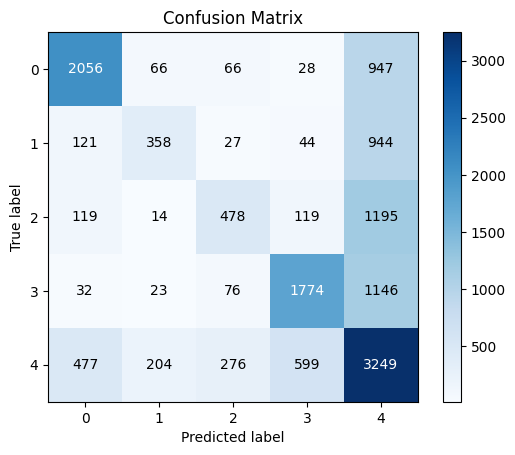

In [31]:
evaluate_features(truncated_tfidf, train_df['label'].values.ravel())

## Word2Vec

class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec 
        self.dim = len(word2vec.vectors[0])

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        #X = MyTokenizer().fit_transform(X)        
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec.vocab]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

In [32]:
#Vectorize using pretrained model
#https://github.com/RaRe-Technologies/gensim-data

info = api.info()  # show info about available models/datasets
w2v_model = api.load("glove-wiki-gigaword-300")  # download the model and return as object ready for use

#Check Word2Vec dimension
w2v_model['word'].shape


(300,)

### Vectorization

In [33]:
mean_embedding_vectorizer = MeanEmbeddingVectorizer(w2v_model) #use pre-trained model from wiki
mean_embedded = mean_embedding_vectorizer.fit_transform(train_df['token'])

## Visualization

In [34]:
w2v_model.most_similar('cancer')

[('prostate', 0.7622983455657959),
 ('breast', 0.730385959148407),
 ('cancers', 0.6897203922271729),
 ('lung', 0.668143630027771),
 ('leukemia', 0.6618481874465942),
 ('tumor', 0.6541092395782471),
 ('disease', 0.647183358669281),
 ('pancreatic', 0.6313984990119934),
 ('alzheimer', 0.6292968392372131),
 ('diagnosed', 0.6266699433326721)]

In [35]:
w2v_model.most_similar('cardiovascular')

[('cardiac', 0.6490300893783569),
 ('diabetes', 0.6253440380096436),
 ('hypertension', 0.599469780921936),
 ('vascular', 0.5443789958953857),
 ('coronary', 0.5410710573196411),
 ('diseases', 0.5388111472129822),
 ('osteoporosis', 0.5303235054016113),
 ('neurological', 0.5298037528991699),
 ('gastrointestinal', 0.5297462940216064),
 ('obesity', 0.5280829668045044)]

In [36]:
w2v_model.most_similar('digest')

[('newsletter', 0.4566918909549713),
 ('reader', 0.4200808107852936),
 ('readers', 0.41179269552230835),
 ('editor', 0.39580702781677246),
 ('magazine', 0.3902829587459564),
 ('sicher', 0.389660120010376),
 ('digests', 0.3808993697166443),
 ('beverage', 0.3745937943458557),
 ('digesting', 0.3722318410873413),
 ('news', 0.3668521046638489)]

### Logistic regression

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.2s finished


--------
class 0 AUC OvR: 0.918
class 1 AUC OvR: 0.901
class 2 AUC OvR: 0.866
class 3 AUC OvR: 0.907
class 4 AUC OvR: 0.688
Avg AUC OvR 0.856
--------
Accuracy: 0.592

              precision    recall  f1-score   support

           0       0.71      0.73      0.72      3163
           1       0.55      0.42      0.48      1494
           2       0.55      0.44      0.49      1925
           3       0.67      0.69      0.68      3051
           4       0.50      0.55      0.52      4805

    accuracy                           0.59     14438
   macro avg       0.60      0.57      0.58     14438
weighted avg       0.59      0.59      0.59     14438



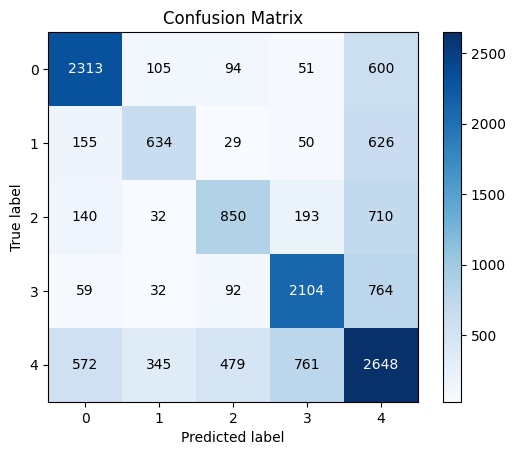

In [37]:
#LR
mcs_LR_1 = evaluate_features(mean_embedded, train_df['label'].values.ravel())

### LightGBM

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   34.1s finished


--------
class 0 AUC OvR: 0.892
class 1 AUC OvR: 0.829
class 2 AUC OvR: 0.810
class 3 AUC OvR: 0.872
class 4 AUC OvR: 0.615
Avg AUC OvR 0.804
--------
Accuracy: 0.503

              precision    recall  f1-score   support

           0       0.67      0.65      0.66      3163
           1       0.31      0.05      0.09      1494
           2       0.46      0.16      0.24      1925
           3       0.63      0.57      0.60      3051
           4       0.40      0.64      0.49      4805

    accuracy                           0.50     14438
   macro avg       0.49      0.42      0.42     14438
weighted avg       0.51      0.50      0.48     14438



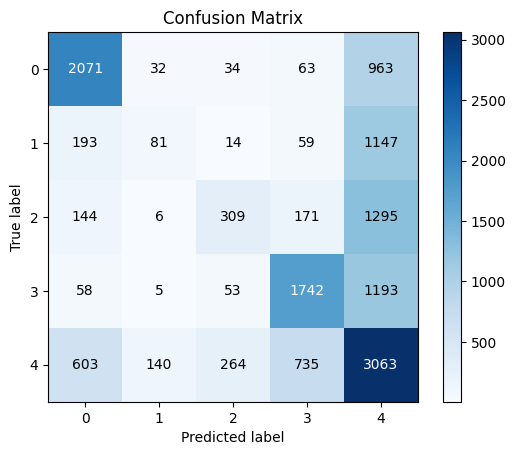

In [38]:
mcs_LGBM_1=evaluate_features(mean_embedded, 
                  train_df['label'].values.ravel(),
                  LGBMClassifier(objective='multiclass', 
                                 learning_rate=0.01)
                 )

### Naive Bayes

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished


--------
class 0 AUC OvR: 0.885
class 1 AUC OvR: 0.842
class 2 AUC OvR: 0.823
class 3 AUC OvR: 0.870
class 4 AUC OvR: 0.646
Avg AUC OvR 0.813
--------
Accuracy: 0.441

              precision    recall  f1-score   support

           0       0.69      0.46      0.55      3163
           1       0.00      0.00      0.00      1494
           2       0.50      0.00      0.00      1925
           3       0.70      0.27      0.39      3051
           4       0.37      0.85      0.51      4805

    accuracy                           0.44     14438
   macro avg       0.45      0.32      0.29     14438
weighted avg       0.49      0.44      0.37     14438



C:\Users\cpw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cpw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cpw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1318: UndefinedM

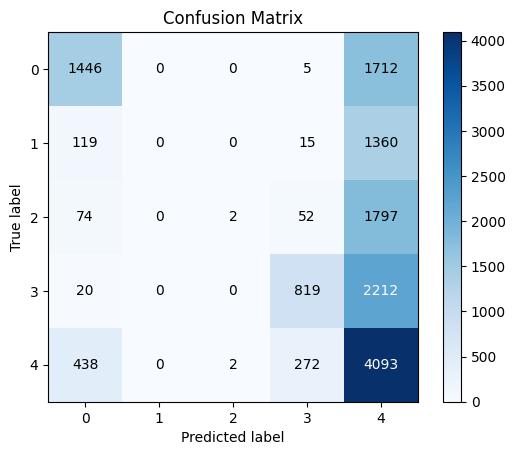

In [39]:
mcs_NB_1 = evaluate_features(MinMaxScaler().fit_transform(mean_embedded), 
                  train_df['label'].values.ravel(),
                  MultinomialNB()                  
                  )

### Neural Network

In [40]:
# define baseline model
def baseline_model():
	# create model
  model = Sequential()
  model.add(Dense(128, input_dim=300, activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(5, activation='softmax'))
  # Compile model
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model


C:\Users\cpw\AppData\Local\Temp\ipykernel_27748\468471823.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  KerasClassifier(build_fn=baseline_model, epochs=5, batch_size=5, verbose=1)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   34.6s finished


--------
class 0 AUC OvR: 0.922
class 1 AUC OvR: 0.901
class 2 AUC OvR: 0.874
class 3 AUC OvR: 0.916
class 4 AUC OvR: 0.696
Avg AUC OvR 0.862
--------
Accuracy: 0.596

              precision    recall  f1-score   support

           0       0.69      0.77      0.73      3163
           1       0.53      0.44      0.48      1494
           2       0.53      0.49      0.51      1925
           3       0.64      0.79      0.71      3051
           4       0.52      0.45      0.49      4805

    accuracy                           0.60     14438
   macro avg       0.58      0.59      0.58     14438
weighted avg       0.59      0.60      0.59     14438



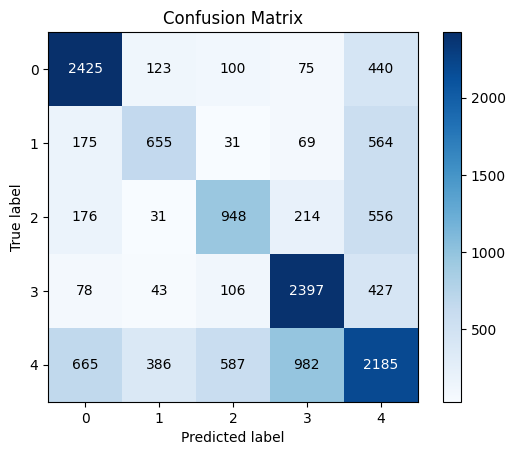

In [41]:
mcs_NN_1= evaluate_features(mean_embedded, 
                  train_df['label'].values.ravel(),
                  KerasClassifier(build_fn=baseline_model, epochs=5, batch_size=5, verbose=1)                
                  )

## FastText

In [44]:
#!pip install fasttext


In [252]:
import os
import fasttext
# Prepare document 
def train_fasttext(data, x_col = 'clean', y_col = 'label' ,file = 'fast'):
  
  file_name = file + '_'   
  try:
    os.remove(file_name+'train')
    os.remove(file_name+'test')
    print('previous file deleted')
  except:
    print('no exist file')

  for x in ['train','test']:
    with open( file_name + x,'w') as f:
      for i in (data[data['data_type']==x]).index:
        f.write('__label__'+str(data[y_col][i])+' '+data[x_col][i])
        f.write('\n')
  f.close()   
  print('Complete loading file, Start training the model')   
  model =fasttext.train_supervised(input= file_name+'train', 
                                   epoch=25, 
                                   wordNgrams=2, 
                                   lr = 0.5)
  
  #evaluate the result 
  preds = []
  df = data[data['data_type']=='test']

  for i in df.index:
    preds.append(model.predict(df['clean'][i])[0][0][-1])
 
  y = df['label'].astype(str)
  print(classification_report(y, preds))
  acc = accuracy_score(y , preds)
  f1 = f1_score(y,preds,average='weighted')
  skplt.metrics.plot_confusion_matrix(y, preds)
  result = {
   'auc': None,
   'accuracy': acc,
    'f1_score': f1
  }  

  return model, result 


previous file deleted
Complete loading file, Start training the model
              precision    recall  f1-score   support

           0       0.64      0.64      0.64       949
           1       0.43      0.40      0.41       448
           2       0.42      0.37      0.39       578
           3       0.59      0.57      0.58       915
           4       0.40      0.44      0.42      1442

    accuracy                           0.50      4332
   macro avg       0.50      0.48      0.49      4332
weighted avg       0.50      0.50      0.50      4332



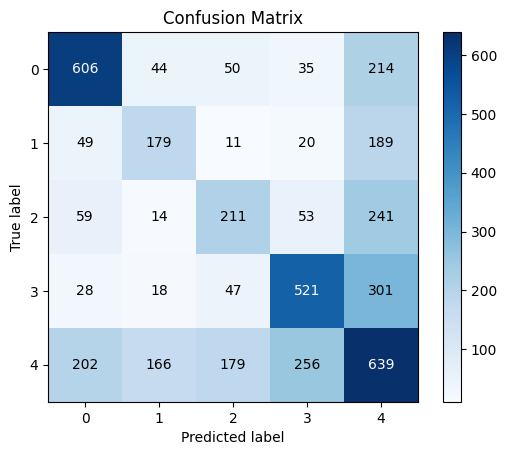

In [255]:
fasttext_model, mcs_ft_1 = train_fasttext(train_df)

In [47]:
#This should be classify as Cardivascular, but it is classify as General

fasttext_model.predict("Myocardial infarction is known as STEMI, require echocardiogram, this is wrong")

(('__label__4',), array([0.9486984]))

In [48]:
fasttext_model.predict("Myocardial infarction is known as STEMI, a.k.a. heart attack, require echocardiogram, this is wrong")


(('__label__3',), array([0.83017379]))

In [49]:
fasttext_model.predict("Lung cancer is one of the most lethal disease in the US")

(('__label__0',), array([0.9997021]))

In [50]:
fasttext_model.test("fast_test")

#Single label
#Precision 0.5
#Recall 0.5

(4332, 0.5004616805170822, 0.5004616805170822)

In [51]:
fasttext_model.test("fast_test", k = 2)

#Multiple label
#Precision 0.4
#Recall 0.86

(4332, 0.4339796860572484, 0.8679593721144968)

Adapted the code of CNN and RNN using the code adapted from "Practical NLP"

In [54]:
#flatten
MAX_NUM_WORDS = len(set([x for y in train_df['token'].to_list() for x in y]))
MAX_SEQUENCE_LENGTH = 1000
EMBEDDING_DIM = 100 

In [55]:
np.max([len(x) for x in train_df['token']]) 

391

In [56]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, LSTM
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.initializers import Constant

In [57]:
#Vectorize these text samples into a 2D integer tensor using Keras Tokenizer 
#Tokenizer is fit on training data only, and that is used to tokenize both train and test data. 
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS) 
tokenizer.fit_on_texts(train_df['clean']) 
train_sequences = tokenizer.texts_to_sequences(train_df[train_df['data_type']=='train']['clean']) #Converting text to a vector of word indexes 
test_sequences = tokenizer.texts_to_sequences(train_df[train_df['data_type']=='test']['clean']) 
word_index = tokenizer.word_index 
print('Found %s unique tokens.' % len(word_index))

Found 35295 unique tokens.


In [58]:
VALIDATION_SPLIT  = 0.2

#Converting this to sequences to be fed into neural network. Max seq. len is 1000 as set earlier
#initial padding of 0s, until vector is of size MAX_SEQUENCE_LENGTH
trainvalid_data = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
trainvalid_labels = to_categorical(np.asarray(train_df[train_df['data_type']=='train']['label']))
test_labels = to_categorical(np.asarray(train_df[train_df['data_type']=='test']['label']))

# split the training data into a training set and a validation set
indices = np.arange(trainvalid_data.shape[0])
np.random.shuffle(indices)
trainvalid_data = trainvalid_data[indices]
trainvalid_labels = trainvalid_labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * trainvalid_data.shape[0])
x_train = trainvalid_data[:-num_validation_samples]
y_train = trainvalid_labels[:-num_validation_samples]
x_val = trainvalid_data[-num_validation_samples:]
y_val = trainvalid_labels[-num_validation_samples:]
#This is the data we will use for CNN and RNN training
print('Splitting the train data into train and valid is done')

Splitting the train data into train and valid is done


In [59]:
EMBEDDING_DIM=300
# first, build index mapping words in the embeddings set
# to their embedding vector
embeddings_index = w2v_model.vectors # {}
#with open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'),encoding='utf8') as f:
#    for line in f:
#        values = line.split()
#        word = values[0]
#        coefs = np.asarray(values[1:], dtype='float32')
#        embeddings_index[word] = coefs

print('Found %s word vectors in Glove embeddings.' % len(embeddings_index))
#print(embeddings_index["google"])
oov = [] #oov list
# prepare embedding matrix - rows are the words from word_index, columns are the embeddings of that word from glove.
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > MAX_NUM_WORDS:
        continue
        print('embedding:',word)
    if word in w2v_model.vocab:
        embedding_vector = w2v_model.get_vector(word)
    else:
        oov.append(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# load these pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)
print("Preparing of embedding matrix is done")
print(f'There are {len(oov)} ({len(oov)/len(word_index)*100:.1f}%) words out of vocabulary')

Found 400000 word vectors in Glove embeddings.
Preparing of embedding matrix is done
There are 12563 (35.6%) words out of vocabulary


In [60]:
print('Define a 1D CNN model.')

cnnmodel = Sequential()
cnnmodel.add(embedding_layer)
cnnmodel.add(Conv1D(128, 5, activation='relu'))
cnnmodel.add(MaxPooling1D(5))
cnnmodel.add(Conv1D(128, 5, activation='relu'))
cnnmodel.add(MaxPooling1D(5))
cnnmodel.add(Conv1D(128, 5, activation='relu'))
cnnmodel.add(GlobalMaxPooling1D())
cnnmodel.add(Dense(128, activation='relu'))
cnnmodel.add(Dense(5, activation='softmax'))

cnnmodel.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])
#Train the model. Tune to validation set. 
cnnmodel.fit(x_train, y_train,
          batch_size=6,
          epochs=10, validation_data=(x_val, y_val))
#Evaluate on test set:
score, acc = cnnmodel.evaluate(test_data, test_labels)
print('Test accuracy with CNN:', acc)


Define a 1D CNN model.
Epoch 1/10
1348/1348 [==============================] - 50s 36ms/step - loss: 1.1453 - acc: 0.5242 - val_loss: 1.0230 - val_acc: 0.5982
Epoch 2/10
1348/1348 [==============================] - 45s 34ms/step - loss: 0.9317 - acc: 0.6208 - val_loss: 1.0166 - val_acc: 0.5829
Epoch 3/10
1348/1348 [==============================] - 45s 34ms/step - loss: 0.8154 - acc: 0.6566 - val_loss: 1.0528 - val_acc: 0.5834
Epoch 4/10
1348/1348 [==============================] - 45s 34ms/step - loss: 0.7142 - acc: 0.6985 - val_loss: 1.0619 - val_acc: 0.5720
Epoch 5/10
1348/1348 [==============================] - 46s 34ms/step - loss: 0.6317 - acc: 0.7306 - val_loss: 1.2447 - val_acc: 0.5626
Epoch 6/10
1348/1348 [==============================] - 46s 34ms/step - loss: 0.5576 - acc: 0.7531 - val_loss: 1.2919 - val_acc: 0.5616
Epoch 7/10
1348/1348 [==============================] - 46s 34ms/step - loss: 0.5165 - acc: 0.7677 - val_loss: 1.3182 - val_acc: 0.5285
Epoch 8/10
1348/1348 [===

In [61]:
print("Defining and training an LSTM model, using pre-trained embedding layer")

rnnmodel2 = Sequential()
rnnmodel2.add(embedding_layer)
rnnmodel2.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
rnnmodel2.add(Dense(5, activation='softmax'))
rnnmodel2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print('Training the RNN')

rnnmodel2.fit(x_train, y_train,
          batch_size=6,
          epochs=10,
          validation_data=(x_val, y_val))
score, acc = rnnmodel2.evaluate(test_data, test_labels,
                            batch_size=32)
print('Test accuracy with RNN:', acc)


Defining and training an LSTM model, using pre-trained embedding layer
Training the RNN
Epoch 1/10
1348/1348 [==============================] - 1420s 1s/step - loss: 1.2216 - accuracy: 0.4962 - val_loss: 1.1587 - val_accuracy: 0.5240
Epoch 2/10
1348/1348 [==============================] - 1394s 1s/step - loss: 1.0886 - accuracy: 0.5532 - val_loss: 1.0223 - val_accuracy: 0.5839
Epoch 3/10
1348/1348 [==============================] - 1424s 1s/step - loss: 0.9335 - accuracy: 0.6193 - val_loss: 0.9424 - val_accuracy: 0.6012
Epoch 4/10
1348/1348 [==============================] - 1431s 1s/step - loss: 0.8516 - accuracy: 0.6469 - val_loss: 0.9373 - val_accuracy: 0.5962
Epoch 5/10
1348/1348 [==============================] - 1454s 1s/step - loss: 0.7871 - accuracy: 0.6659 - val_loss: 0.9818 - val_accuracy: 0.5863
Epoch 6/10
1348/1348 [==============================] - 1453s 1s/step - loss: 0.7313 - accuracy: 0.6816 - val_loss: 0.9583 - val_accuracy: 0.5769
Epoch 7/10
1348/1348 [==============

### CNN/RNN Result

The CNN and RNN are no better than Keras classification

In [262]:
Preliminary_result = pd.DataFrame(data={
    'LR':mcs_LR_1,
    'NB':mcs_NB_1,
    'LGBM':mcs_LGBM_1,
    'NN':mcs_NN_1,
    'Fasttext': mcs_ft_1
})
Preliminary_result

,LR,NB,LGBM,NN,Fasttext
auc,0.856015,0.813091,0.803635,0.861658,NaN
accuracy,0.592118,0.440504,0.503255,0.596343,0.497692
f1_score,0.590090,0.373360,0.476866,0.588256,0.498049


So the result is suboptimal, how can we improve it ?

# [Method #1] Re-label class General

In above classification result, we can find that the models have difficulty to label class General. 

**Solution:**
1. Build the model without class General and evaluate the performance (LR, XGboost, FastText)
2. Attempt re-label class General



### Train model to classify 1-4

In [62]:
# dataset 2 - without label 4 - general 
train_df_2 = train_df[train_df['label']!=4]
mean_embedded_2 = mean_embedding_vectorizer.fit_transform(train_df_2['token'])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.0s finished


--------
class 0 AUC OvR: 0.943
class 1 AUC OvR: 0.935
class 2 AUC OvR: 0.909
class 3 AUC OvR: 0.952
Avg AUC OvR 0.935
--------
Accuracy: 0.794

              precision    recall  f1-score   support

           0       0.82      0.84      0.83      3163
           1       0.73      0.69      0.71      1494
           2       0.72      0.69      0.71      1925
           3       0.83      0.86      0.85      3051

    accuracy                           0.79      9633
   macro avg       0.78      0.77      0.77      9633
weighted avg       0.79      0.79      0.79      9633



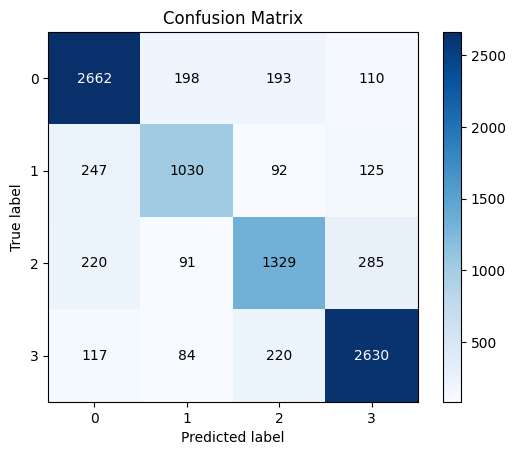

In [63]:
#LR 
mcs_LR_2 = evaluate_features(mean_embedded_2, train_df_2['label'].values.ravel())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished


--------
class 0 AUC OvR: 0.916
class 1 AUC OvR: 0.880
class 2 AUC OvR: 0.863
class 3 AUC OvR: 0.912
Avg AUC OvR 0.893
--------
Accuracy: 0.659

              precision    recall  f1-score   support

           0       0.68      0.88      0.77      3163
           1       0.76      0.07      0.13      1494
           2       0.75      0.38      0.50      1925
           3       0.62      0.90      0.73      3051

    accuracy                           0.66      9633
   macro avg       0.70      0.56      0.53      9633
weighted avg       0.69      0.66      0.60      9633



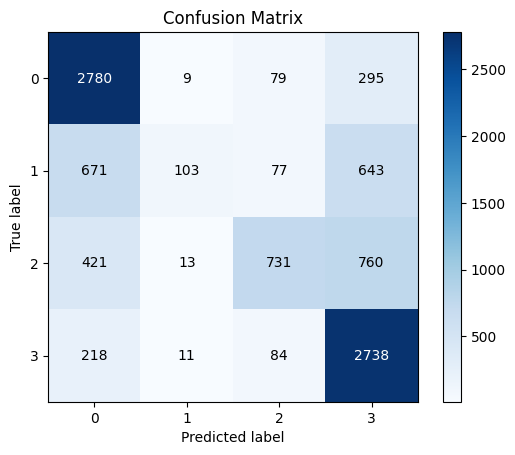

In [64]:
#ML LGB
mcs_NB_2 = evaluate_features(MinMaxScaler().fit_transform(mean_embedded_2), 
                  train_df_2['label'].values.ravel(),
                  MultinomialNB()
                 )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.2s finished


--------
class 0 AUC OvR: 0.917
class 1 AUC OvR: 0.875
class 2 AUC OvR: 0.865
class 3 AUC OvR: 0.923
Avg AUC OvR 0.895
--------
Accuracy: 0.713

              precision    recall  f1-score   support

           0       0.72      0.85      0.78      3163
           1       0.70      0.36      0.47      1494
           2       0.70      0.53      0.60      1925
           3       0.71      0.86      0.78      3051

    accuracy                           0.71      9633
   macro avg       0.71      0.65      0.66      9633
weighted avg       0.71      0.71      0.70      9633



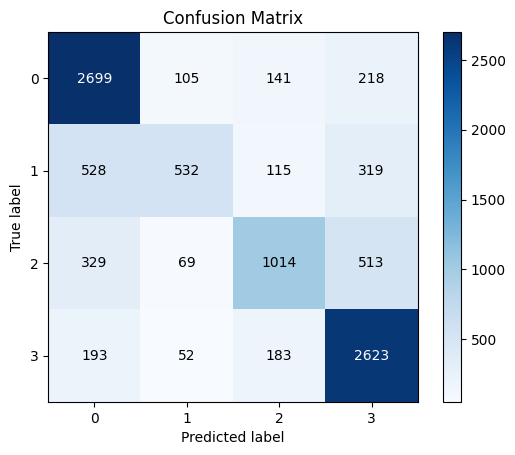

In [65]:
#ML LGB
mcs_LGBM_2 = evaluate_features(mean_embedded_2, 
                  train_df_2['label'].values.ravel(),
                  LGBMClassifier(objective='multiclass', 
                                 learning_rate=0.01)
                 )

C:\Users\cpw\AppData\Local\Temp\ipykernel_27748\3684394494.py:13: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  KerasClassifier(build_fn=baseline_model, epochs=5, batch_size=5, verbose=0)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.6s finished


--------
class 0 AUC OvR: 0.949
class 1 AUC OvR: 0.938
class 2 AUC OvR: 0.918
class 3 AUC OvR: 0.954
Avg AUC OvR 0.940
--------
Accuracy: 0.792

              precision    recall  f1-score   support

           0       0.83      0.83      0.83      3163
           1       0.70      0.74      0.72      1494
           2       0.73      0.68      0.71      1925
           3       0.84      0.85      0.84      3051

    accuracy                           0.79      9633
   macro avg       0.77      0.77      0.77      9633
weighted avg       0.79      0.79      0.79      9633



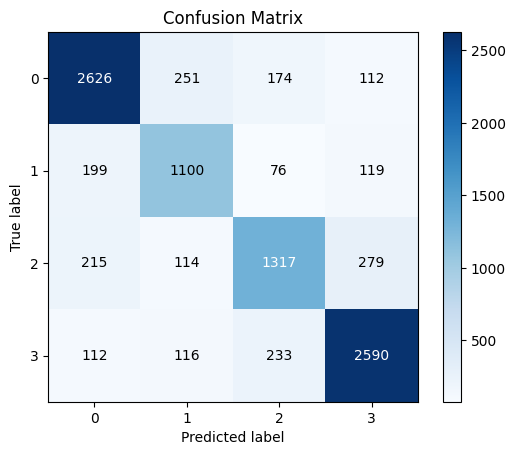

In [66]:
def baseline_model():
	# create model
  model = Sequential()
  model.add(Dense(128, input_dim=300, activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(4, activation='softmax'))
  # Compile model
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

mcs_NN_2 = evaluate_features(mean_embedded_2, 
                  train_df_2['label'].values.ravel(),
                  KerasClassifier(build_fn=baseline_model, epochs=5, batch_size=5, verbose=0)                
                  )

previous file deleted
Complete loading file, Start training the model
              precision    recall  f1-score   support

           0       0.81      0.81      0.81       949
           1       0.74      0.71      0.72       448
           2       0.70      0.69      0.69       578
           3       0.82      0.84      0.83       915

    accuracy                           0.78      2890
   macro avg       0.77      0.76      0.77      2890
weighted avg       0.78      0.78      0.78      2890



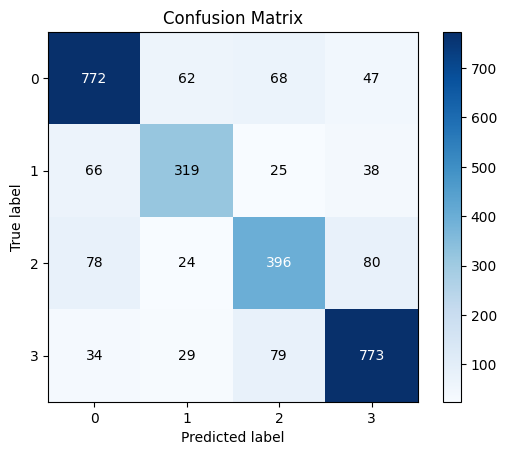

In [258]:
##Fast Text
fasttext_model_2, mcs_ft_2 = train_fasttext(train_df_2)

In [69]:
#test this description from group 5
testing_msg =  train_df[train_df['label']==4]['clean'][6]
testing_msg

'mediastinal tracheostomy using pectoralis major myocutaneous flap resection carcinoma esophagus involving proximal part trachea operative procedure mediastinal tracheostomy using pectoralis major myocutaneous flap presented procedure terminal portion trachea penetrates center pectoralis major myocutaneous flap tracheal wall completely wrapped muscular portion flap 1981 1988 eight patient carcinoma cervicothoracic segment esophagus underwent mediastinal tracheostomy laryngoesophagectomy extended resection proximal part trachea sternal manubrectomy invasion trachea five eight patient pectoralis major myocutaneous flap used construct tracheal stoma skin flap skin flap muscle flap used three four eight patient tracheal necrosis occurred rupture brachiocephalic artery occurred one patient tracheal stoma constructed using skin flap muscle flap however neither skin breakdown bleeding major vessel occurred using myocutaneous flap therefore concluded construction tracheal stoma using pectorali

In [70]:
#This is indeed cancer 
fasttext_model_2.predict(testing_msg) 

(('__label__0',), array([0.99261087]))

In [71]:
fasttext_model_2.test("fast_test")

#Single label
#Precision 0.78
#Recall 0.78

(2890, 0.7813148788927335, 0.7813148788927335)

In [72]:
fasttext_model_2.test("fast_test",k = 2)

(2890, 0.4745674740484429, 0.9491349480968858)

In [263]:
Preliminary_result['LR_2'] = mcs_LR_2
Preliminary_result['NB_2'] = mcs_NB_2
Preliminary_result['LGBM_2'] = mcs_LGBM_2
Preliminary_result['NN_2'] = mcs_NN_2
Preliminary_result['Fasttext_2'] = mcs_ft_2
Preliminary_result

,LR,NB,LGBM,NN,Fasttext,LR_2,NB_2,LGBM_2,NN_2,Fasttext_2
auc,0.856015,0.813091,0.803635,0.861658,NaN,0.934816,0.892644,0.895238,0.939703,NaN
accuracy,0.592118,0.440504,0.503255,0.596343,0.497692,0.794249,0.659400,0.712966,0.792380,0.782007
f1_score,0.590090,0.373360,0.476866,0.588256,0.498049,0.793010,0.603842,0.696781,0.792070,0.781494


# [Method #2] Multi-label classification

In [281]:
multi_train, multi_test, y_train, y_test = train_test_split(  multi_df['token'], 
                                                              multi_df.drop(['desc','token','clean'],axis=1),
                                                              random_state=42, 
                                                              test_size=0.30, 
                                                              shuffle=True)

x_train = mean_embedding_vectorizer.fit_transform(multi_train)
x_test = mean_embedding_vectorizer.fit_transform(multi_test)

## Use Multiple One vs Rest Method

In [74]:
from sklearn.multiclass import OneVsRestClassifier
# Using pipeline for applying logistic regression and one vs rest classifier
LogReg_pipeline = Pipeline([
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1)),
            ])

result = pd.DataFrame()
for category in range(0,5):

  category = str(category)
  # Training logistic regression model on train data
  LogReg_pipeline.fit(x_train, y_train[category])
  
  proba = LogReg_pipeline.predict_proba(x_test)
  prediction = LogReg_pipeline.predict(x_test)
  
  result = result.append({
      'AUC OvR' : round(roc_auc_score(y_test[category],proba[:,1]) ,3 ),
      'accuracy' : round(accuracy_score(y_test[category], prediction),3),
      'F1 score' : round(f1_score(y_test[category], prediction),3)
  },ignore_index= True)

result

C:\Users\cpw\AppData\Local\Temp\ipykernel_27748\605238866.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({
C:\Users\cpw\AppData\Local\Temp\ipykernel_27748\605238866.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({
C:\Users\cpw\AppData\Local\Temp\ipykernel_27748\605238866.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({
C:\Users\cpw\AppData\Local\Temp\ipykernel_27748\605238866.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({
C:\Users\cpw\AppData\Local\Temp\ipykernel_27748\605238866.py:17: FutureWarning: The frame.append met

,AUC OvR,accuracy,F1 score
0,0.952,0.913,0.831
1,0.930,0.922,0.642
2,0.889,0.881,0.597
3,0.945,0.903,0.812
4,0.751,0.688,0.617


## Classifier Chain

In [75]:
!pip install scikit-multilearn

In [76]:
#https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff

# using classifier chains
from skmultilearn.problem_transform import ClassifierChain

# initialize classifier chains multi-label classifier
classifier = ClassifierChain(LogisticRegression()).fit(x_train, y_train)
predictions = classifier.predict(x_test)

print("F1_score = ",f1_score(y_test,predictions,average='weighted'))
print("Accuracy = ",accuracy_score(y_test,predictions))
print("\n")

F1_score =  0.7253784704511267
Accuracy =  0.5571386168002375




C:\Users\cpw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [285]:
multi_df_2 = multi_df[multi_df['4']==0]

In [287]:
multi_train_2, multi_test_2, y_train_2, y_test_2 = train_test_split(  multi_df_2['token'], 
                                                              multi_df_2.drop(['4','desc','token','clean'],axis=1),
                                                              random_state=42, 
                                                              test_size=0.30, 
                                                              shuffle=True)

x_train_2 = mean_embedding_vectorizer.fit_transform(multi_train_2)
x_test_2 = mean_embedding_vectorizer.fit_transform(multi_test_2)

In [288]:

predictions_2 = ClassifierChain(LogisticRegression()).fit(x_train_2, y_train_2).predict(x_test_2)

print("F1_score = ",f1_score(y_test_2,predictions_2,average='weighted'))
print("Accuracy = ",accuracy_score(y_test_2,predictions_2))
print("\n")

F1_score =  0.8375344605353615
Accuracy =  0.7955371043072132




# Re-label Class 5 - General - Using fasttext

In [77]:
train_df[train_df['label']==4]['unique'].value_counts()

1    3509
0    1296
Name: unique, dtype: int64

In [78]:
def fast_predict(label, desc):
  if label == 4:
    try:  #if threshold > 0.85, return new label, We intentially set it higher, so we don't over label people to other classes
      return fasttext_model_2.predict(desc, threshold= 0.85)[0][0][-1]
    except: #else return 4
      return label
  else:
    return label  

train_df['new_label'] = train_df[['label','clean']].apply(lambda x: fast_predict(x.label, x.clean), axis=1)
train_df['new_label'] = train_df['new_label'].astype(int)



In [79]:
train_df[train_df['label']==4].head(8)[['clean','label','new_label']]

#Let's go back to check if new classification is valid

# 1- Renal abscess in children - ID / General                                              - [Wrong] GI 
# 2- Subclavian artery to innominate vein fistula - Cardiovascular [Wrong Label]           - [Correct] Cardiovascular 
# 3- Mediastinal tracheostomy for esophageal cancer - Cancer [Wrong Label]                 - [Correct] Cancer 
# 4- idiopathic fibroinflammatory - Derm / General                                         - [wrong] cancer 
# 5- Asthma  - Pulm / General                                                              - [Correct] Geneneral 
# 6- automatic implantable cardioverter defibrillator - cardiovascuar [Wrong label]        - [Correct] cardiovascular 
# 7- stress-related mucosal damage - GI [Wrong Label]                                      - [Correct] GI 
# 8- HSV encephalitis - ID / General                                                       - [Correct] ID /General


# From observation, we find that FastText successfully learn the labels that we thought it was wrong, however, it also categorize some statement to other classes

,clean,label,new_label
1,renal abscess child three case renal abscess c...,4,1
3,subclavian artery innominate vein fistula inse...,4,3
6,mediastinal tracheostomy using pectoralis majo...,4,0
7,tumefactive fibroinflammatory lesion extremity...,4,0
9,increasing asthma prevalence rural new zealand...,4,4
10,usefulness automatic implantable cardioverter ...,4,3
11,stress-related mucosal damage review drug ther...,4,1
13,controlled trial comparing vidarabine acyclovi...,4,4


In [80]:
train_df['new_label'].value_counts().sort_index()

0    3879
1    2043
2    2674
3    4108
4    1734
Name: new_label, dtype: int64

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.3s finished


--------
class 0 AUC OvR: 0.946
class 1 AUC OvR: 0.932
class 2 AUC OvR: 0.911
class 3 AUC OvR: 0.952
class 4 AUC OvR: 0.842
Avg AUC OvR 0.916
--------
Accuracy: 0.743

              precision    recall  f1-score   support

           0       0.80      0.83      0.81      3879
           1       0.70      0.69      0.70      2043
           2       0.69      0.71      0.70      2674
           3       0.81      0.86      0.84      4108
           4       0.51      0.37      0.43      1734

    accuracy                           0.74     14438
   macro avg       0.70      0.69      0.70     14438
weighted avg       0.73      0.74      0.74     14438



{'auc': 0.9163785227473534,
 'accuracy': 0.7433162487879208,
 'f1_score': 0.7371135298887194}

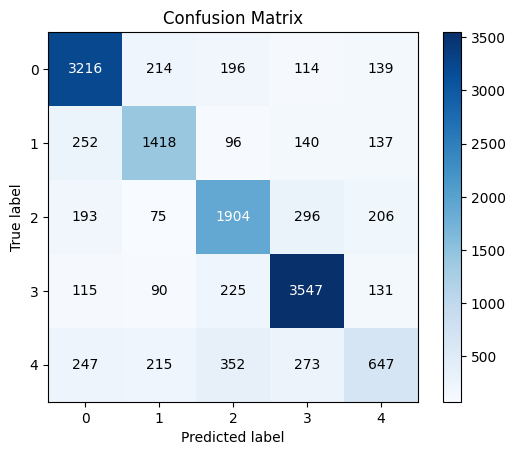

In [81]:
#Evaluate with LR to check the classification report with new label system
#LR
evaluate_features(mean_embedded, train_df['new_label'].values.ravel())


**Relabeling result peek:**

The result from LR is promosing, then we will use the new label dataset to train the rest of the models. 


# Task 2/3 Build models and evaluate performance

In [83]:
import pickle
from gensim.test.utils import get_tmpfile

file_path = 'model/'

In [84]:
#embedding

mean_embedded_train = mean_embedding_vectorizer.fit_transform(train_df[train_df['data_type'] == 'train']['token'])
mean_embedded_test = mean_embedding_vectorizer.fit_transform(train_df[train_df['data_type'] == 'test']['token'])

y_train_new = train_df[train_df['data_type'] == 'train']['new_label']
y_test_new = train_df[train_df['data_type'] == 'test']['new_label']


## LogisticRegression

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished


--------
class 0 AUC OvR: 0.945
class 1 AUC OvR: 0.931
class 2 AUC OvR: 0.891
class 3 AUC OvR: 0.946
class 4 AUC OvR: 0.827
Avg AUC OvR 0.908
--------
Accuracy: 0.726

              precision    recall  f1-score   support

           0       0.79      0.83      0.81      1163
           1       0.68      0.69      0.68       621
           2       0.65      0.67      0.66       804
           3       0.80      0.86      0.83      1225
           4       0.49      0.31      0.38       519

    accuracy                           0.73      4332
   macro avg       0.68      0.67      0.67      4332
weighted avg       0.71      0.73      0.72      4332



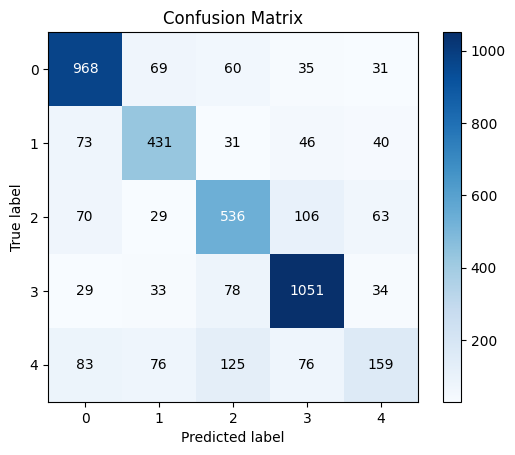

In [85]:
mcs_LR_3 = evaluate_features(X = mean_embedded_test,
           y = y_test_new, 
           model= LogisticRegression()
)


### Naive Bayes


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


--------
class 0 AUC OvR: 0.910
class 1 AUC OvR: 0.860
class 2 AUC OvR: 0.850
class 3 AUC OvR: 0.912
class 4 AUC OvR: 0.741
Avg AUC OvR 0.855
--------
Accuracy: 0.597

              precision    recall  f1-score   support

           0       0.66      0.83      0.74      1163
           1       0.65      0.17      0.27       621
           2       0.59      0.50      0.54       804
           3       0.55      0.90      0.69      1225
           4       0.36      0.01      0.02       519

    accuracy                           0.60      4332
   macro avg       0.56      0.48      0.45      4332
weighted avg       0.58      0.60      0.53      4332



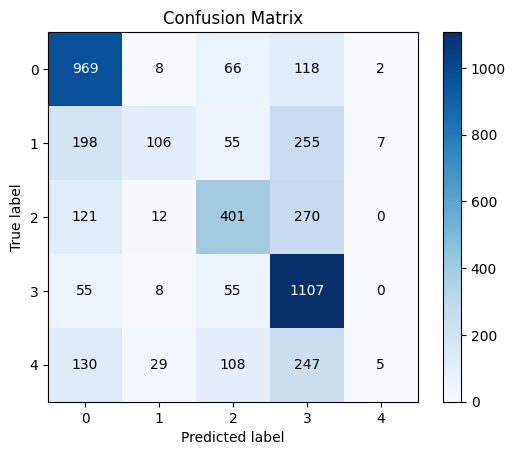

In [86]:

pipe_nb = make_pipeline(MinMaxScaler(),
                        MultinomialNB()
)

naive = pipe_nb.fit(mean_embedded_train,y_train_new)

mcs_NB_3= evaluate_features(X = MinMaxScaler().fit_transform(mean_embedded_test),
           y = y_test_new,
           model = naive   
)

pickle.dump(naive, open(file_path+'nb.model','wb'))  #NB

### LightGBM

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   33.1s finished


--------
class 0 AUC OvR: 0.910
class 1 AUC OvR: 0.873
class 2 AUC OvR: 0.853
class 3 AUC OvR: 0.920
class 4 AUC OvR: 0.762
Avg AUC OvR 0.864
--------
Accuracy: 0.632

              precision    recall  f1-score   support

           0       0.66      0.83      0.74      1163
           1       0.61      0.39      0.48       621
           2       0.59      0.55      0.57       804
           3       0.65      0.86      0.74      1225
           4       0.30      0.07      0.11       519

    accuracy                           0.63      4332
   macro avg       0.56      0.54      0.53      4332
weighted avg       0.60      0.63      0.60      4332



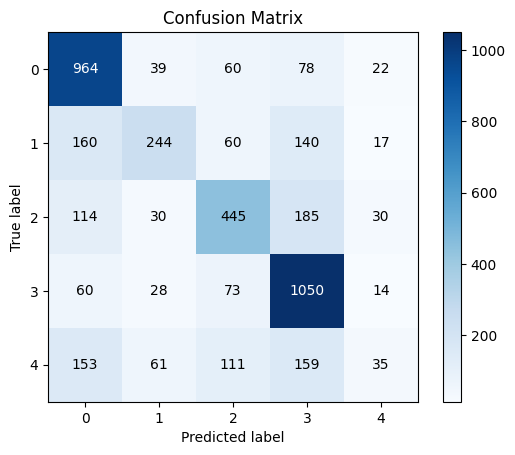

In [87]:
param_grid = {
    'num_leaves': [31, 127],
    'reg_alpha': [0.1, 0.5],
    'min_data_in_leaf': [30],
    }

lgb_estimator = LGBMClassifier(boosting_type='gbdt',  
                               objective='multiclass', 
                               learning_rate=0.01)

lgb_model = GridSearchCV(estimator=lgb_estimator, 
                        param_grid=param_grid, 
                        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)).fit(mean_embedded_train, y_train_new)

mcs_LGBM_3= evaluate_features(mean_embedded_test,
           y_test_new,
           lgb_model.best_estimator_  
)

pickle.dump(lgb_model.best_estimator_, open(file_path+'lgbm.model','wb'))  #LGBM

### Neural Network

C:\Users\cpw\AppData\Local\Temp\ipykernel_27748\3430809650.py:12: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  NN_model = KerasClassifier(build_fn=baseline_model,


 66/136 [=============>................] - ETA: 0s

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


136/136 [==============================] - 0s 759us/step
--------
class 0 AUC OvR: 0.934
class 1 AUC OvR: 0.922
class 2 AUC OvR: 0.882
class 3 AUC OvR: 0.939
class 4 AUC OvR: 0.806
Avg AUC OvR 0.896
--------
Accuracy: 0.703

              precision    recall  f1-score   support

           0       0.77      0.81      0.79      1163
           1       0.65      0.71      0.68       621
           2       0.70      0.54      0.61       804
           3       0.83      0.80      0.82      1225
           4       0.39      0.48      0.43       519

    accuracy                           0.70      4332
   macro avg       0.67      0.67      0.67      4332
weighted avg       0.71      0.70      0.70      4332



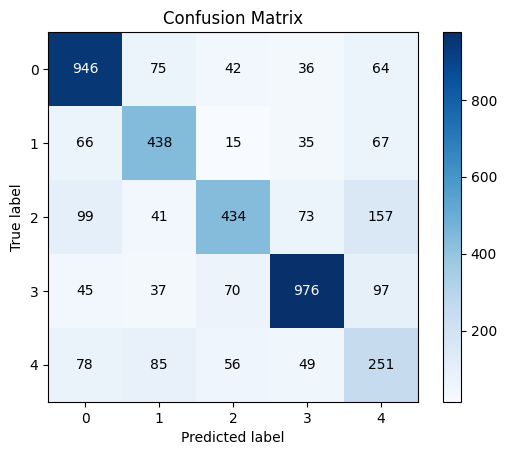

In [88]:
def baseline_model():
	# create model
  model = Sequential()
  model.add(Dense(128, input_dim=300, activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(5, activation='softmax'))
  # Compile model
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model


NN_model = KerasClassifier(build_fn=baseline_model, 
                           epochs=30, 
                           batch_size=10, verbose=0).fit(mean_embedded_train, y_train_new, validation_split = 0.3 )


mcs_NN_3 = evaluate_features(X = mean_embedded_test,
           y = y_test_new,
           model = NN_model   
)

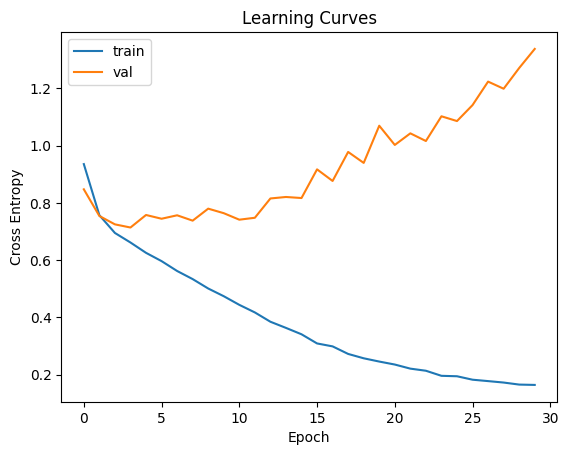

In [89]:
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.plot(NN_model.history['loss'], label='train')
plt.plot(NN_model.history['val_loss'], label='val')
plt.legend()
plt.show()

#overfitting when Epoch > 3

Epoch 1/3


C:\Users\cpw\AppData\Local\Temp\ipykernel_27748\656798352.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  NN_model = KerasClassifier(build_fn=baseline_model,


1011/1011 [==============================] - 1s 916us/step - loss: 0.8783 - accuracy: 0.6814
Epoch 2/3
1011/1011 [==============================] - 1s 918us/step - loss: 0.7283 - accuracy: 0.7406
Epoch 3/3
136/136 [==============================] - 0s 759us/step
--------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


class 0 AUC OvR: 0.952
class 1 AUC OvR: 0.938
class 2 AUC OvR: 0.908
class 3 AUC OvR: 0.957
class 4 AUC OvR: 0.860
Avg AUC OvR 0.923
--------
Accuracy: 0.736

              precision    recall  f1-score   support

           0       0.82      0.81      0.82      1163
           1       0.64      0.77      0.70       621
           2       0.67      0.68      0.67       804
           3       0.84      0.84      0.84      1225
           4       0.49      0.37      0.42       519

    accuracy                           0.74      4332
   macro avg       0.69      0.69      0.69      4332
weighted avg       0.73      0.74      0.73      4332



INFO:tensorflow:Assets written to: model/NN.model\assets


INFO:tensorflow:Assets written to: model/NN.model\assets


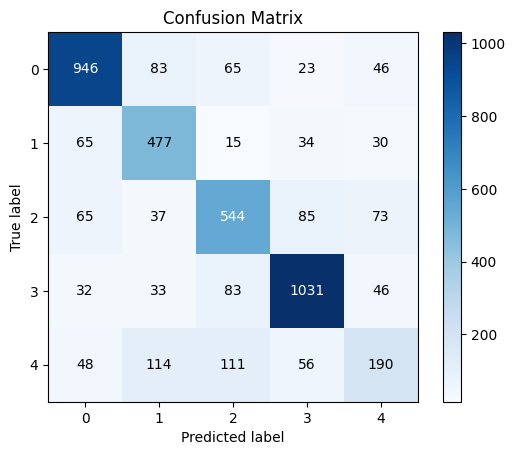

In [90]:
NN_model = KerasClassifier(build_fn=baseline_model, 
                           epochs=3, 
                           batch_size=10, verbose=1).fit(mean_embedded_train, y_train_new)


mcs_NN_3 = evaluate_features(X = mean_embedded_test,
           y = y_test_new,
           model = NN_model   
)

NN_model.model.save(file_path+'NN.model') #NN

### Fasttext

previous file deleted
Complete loading file, Start training the model
              precision    recall  f1-score   support

           0       0.63      0.79      0.70       949
           1       0.47      0.64      0.54       448
           2       0.44      0.59      0.51       578
           3       0.60      0.81      0.69       915
           4       0.62      0.23      0.33      1442

    accuracy                           0.57      4332
   macro avg       0.55      0.61      0.56      4332
weighted avg       0.58      0.57      0.53      4332



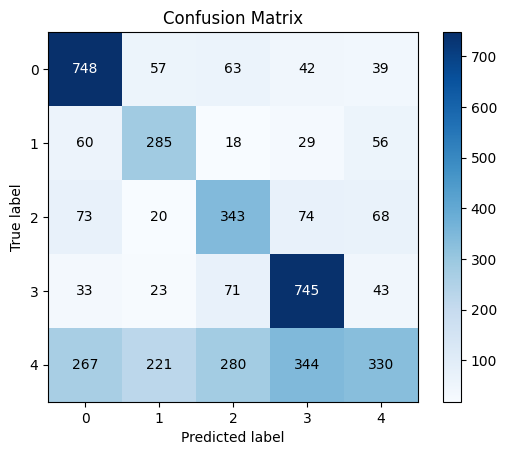

In [267]:
final_fasttext, mcs_FT_3 = train_fasttext(train_df, 
                                x_col = 'clean',
                                y_col = 'new_label',
                                file = 'final_fast')

final_fasttext.save_model(file_path+'fasttext.model') #fast_test

# Visualization

In [269]:
Preliminary_result['LR_3'] = mcs_LR_3
Preliminary_result['NB_3'] = mcs_NB_3
Preliminary_result['LGBM_3'] = mcs_LGBM_3
Preliminary_result['NN_3'] = mcs_NN_3
Preliminary_result['Fasttext_3'] = mcs_FT_3
Preliminary_result

,LR,NB,LGBM,NN,Fasttext,LR_2,NB_2,LGBM_2,NN_2,Fasttext_2,LR_3,NB_3,LGBM_3,NN_3,Fasttext_3
auc,0.856015,0.813091,0.803635,0.861658,NaN,0.934816,0.892644,0.895238,0.939703,NaN,0.907992,0.854515,0.863656,0.922918,NaN
accuracy,0.592118,0.440504,0.503255,0.596343,0.497692,0.794249,0.659400,0.712966,0.792380,0.782007,0.725993,0.597415,0.632041,0.735919,0.565789
f1_score,0.590090,0.373360,0.476866,0.588256,0.498049,0.793010,0.603842,0.696781,0.792070,0.781494,0.716887,0.532667,0.595241,0.731685,0.534955


In [277]:
def plot_metrics(df, metric = 'auc', ):
   
    ax = sns.barplot(data = df[ (df['pass']==1) |(df['pass']==3) ], 
                x = 'model', y= metric , hue = 'pass', palette='Paired')

    for i in ax.containers:
        ax.bar_label(i,)

    plt.title( label = 'Performance Metrics: '+ metric )
    plt.legend(['Initial','Final'],title = 'Attempts', loc=4 )
    #plt.xlim([0,1])

In [271]:
data_list = ['LR','NB','LGBM','NN','Fasttext']
result = Preliminary_result.T.round(3)

for x in data_list:
    for y in result.index:
        if x in y:
            result.loc[y,'model'] = x    
        if y[-1] in ['2','3']:
            result.loc[y,'pass'] = int(y[-1])
        else:
            result.loc[y,'pass'] = 1


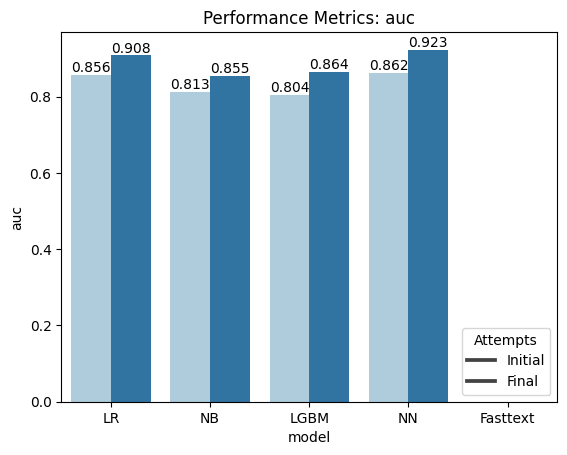

In [278]:
plot_metrics(result,'auc')

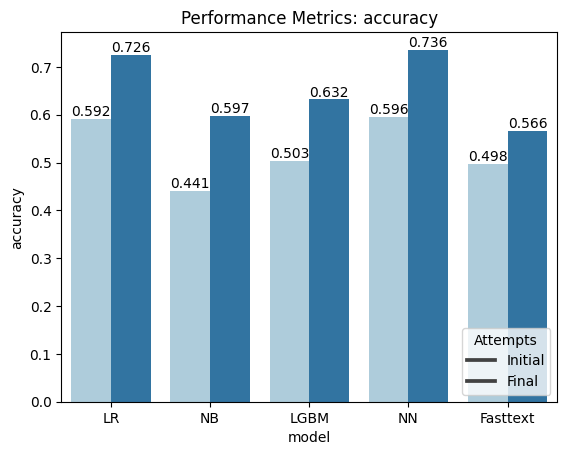

In [279]:
plot_metrics(result,'accuracy')

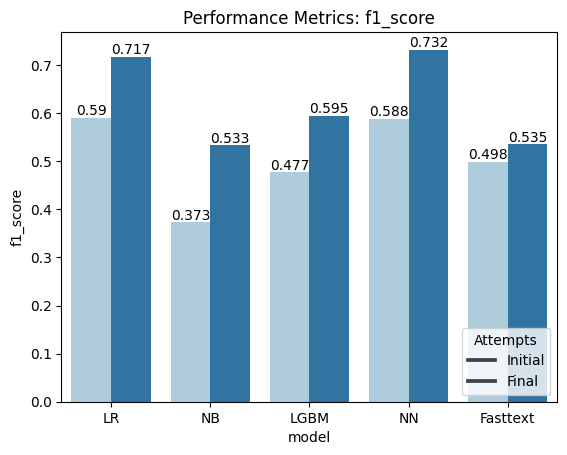

In [280]:
plot_metrics(result,'f1_score')

# Label Test Data Set


In [95]:
#Seperation of labels and text data

test_df = pd.DataFrame()

with open("data/test.dat", "r") as f:
     test_data = f.readlines()
     f.close()

test_df = pd.DataFrame( data = { 'desc': test_data   })
test_df['token'] = [preprocess(x) for x in test_df.desc]

mean_embedding_test = mean_embedding_vectorizer.fit_transform(test_df['token'])


In [96]:
def sanity_check(model):
  try: 
    test_df['label'] = np.argmax(model.predict(mean_embedding_test), axis=1)
  except:
    test_df['label'] = model.predict(mean_embedding_test)
  
  test_df['label_desc'] =test_df['label'].map(dz_dict)
  preds = test_df['label_desc']
  plt.figure(figsize=(8, 5))
  sns.countplot(x = test_df['label_desc'].sort_values())  

  print('Distribution:')
  return preds

452/452 [==============================] - 0s 755us/step
Distribution:


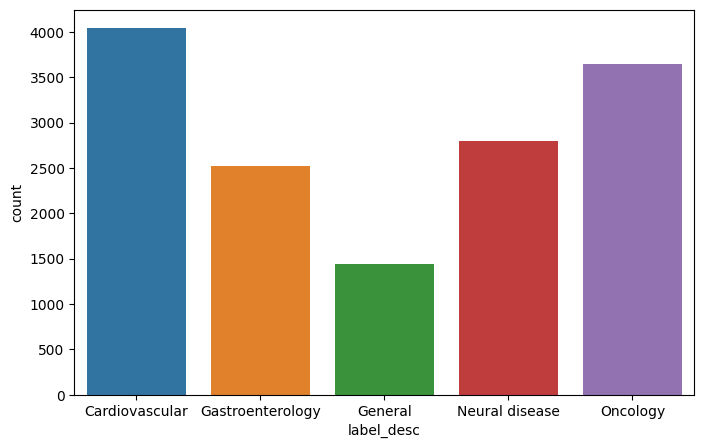

In [97]:
test_df['NN'] = sanity_check(NN_model.model)

Distribution:


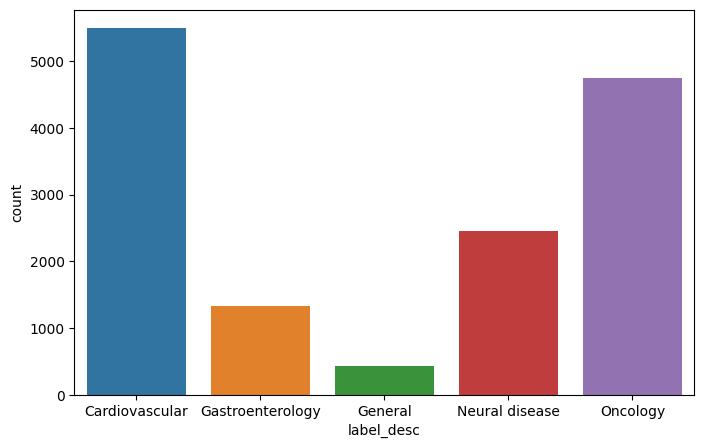

In [98]:
test_df['lgbm'] = sanity_check(model= lgb_model.best_estimator_)




Distribution:


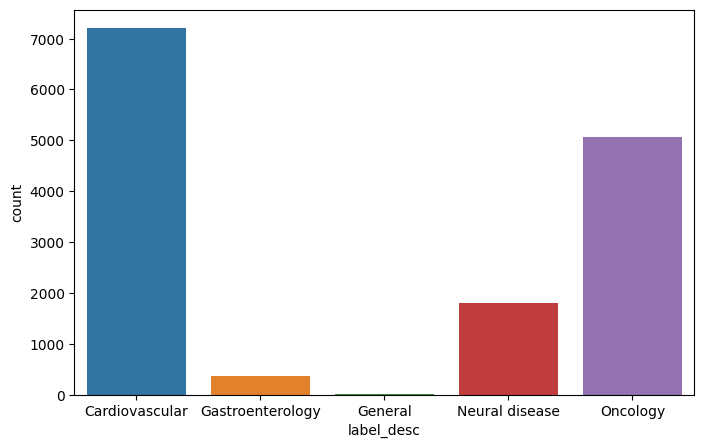

In [99]:
test_df['NB'] =sanity_check(model= naive)

<AxesSubplot: xlabel='FastText', ylabel='count'>

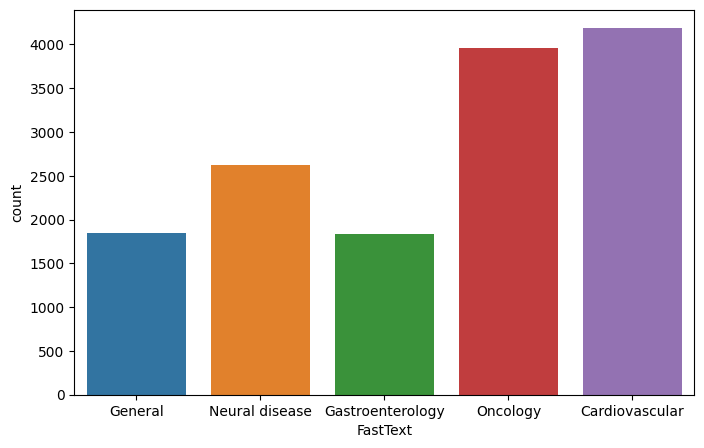

In [100]:
test_df['FastText'] = [final_fasttext.predict(' '.join(x))[0][0][-1] for x in test_df['token']]
test_df['FastText'] = test_df['FastText'].astype(int).map(dz_dict)

plt.figure(figsize=[8,5])
sns.countplot(x = test_df['FastText'])

In [101]:
test_df.head(10)

,desc,token,label,label_desc,NN,lgbm,NB,FastText
0,Excision of limbal dermoids. We reviewed the c...,"[excision, limbal, dermoids, reviewed, clinica...",3,Cardiovascular,General,General,Cardiovascular,General
1,Bell's palsy. A diagnosis of exclusion. In cas...,"[bell, 's, palsy, diagnosis, exclusion, case, ...",2,Neural disease,Neural disease,Neural disease,Neural disease,Neural disease
2,Retained endobronchial foreign body removal fa...,"[retained, endobronchial, foreign, body, remov...",0,Oncology,Oncology,Gastroenterology,Oncology,General
3,Recurrent buccal space abscesses: a complicati...,"[recurrent, buccal, space, abscess, complicati...",1,Gastroenterology,Gastroenterology,Gastroenterology,Gastroenterology,Gastroenterology
4,Intracranial fibromatosis. Fibromatoses are un...,"[intracranial, fibromatosis, fibromatoses, unc...",0,Oncology,Oncology,Oncology,Oncology,Oncology
5,The effect of intrathecal morphine on somatose...,"[effect, intrathecal, morphine, somatosensory,...",3,Cardiovascular,Neural disease,Cardiovascular,Cardiovascular,Cardiovascular
6,The 29th Rovenstine lecture: clinical challeng...,"[29th, rovenstine, lecture, clinical, challeng...",2,Neural disease,Oncology,Cardiovascular,Neural disease,Neural disease
7,Mortality in patients treated with flecainide ...,"[mortality, patient, treated, flecainide, enca...",3,Cardiovascular,Cardiovascular,Cardiovascular,Cardiovascular,Cardiovascular
8,Approaches to immunotherapy of cancer: charact...,"[approach, immunotherapy, cancer, characteriza...",0,Oncology,Oncology,Oncology,Oncology,Oncology
9,Retinal artery obstruction and atheromas assoc...,"[retinal, artery, obstruction, atheroma, assoc...",0,Oncology,Cardiovascular,Cardiovascular,Oncology,Cardiovascular


In [102]:
#let's doublec check what's going on with index 0, 2, 5, 9

for i in [0,2,5,9]:
  print('index:',i)
  pprint(test_df.iloc[i]['desc'],width=100)
  print('\n')

#0 -- it's a dermatology case, should be general 
#2 -- It's a pulmonary case with endobronchial polyp  -- general 
#5 -- It's Neurology case (Neural network is correct, others are wrong)
#9 -- It's a retinal artery obstscrtion from lymphoma -- both Oncology and Cardiovascular are correct 


index: 0
('Excision of limbal dermoids. We reviewed the clinical files of 10 patients who had undergone '
 'excision of unilateral epibulbar limbal dermoids. Preoperatively, all of the affected eyes had '
 'worse visual acuity (P less than .02) and more astigmatism (P less than .01) than the '
 'contralateral eyes. Postoperatively, every patient was cosmetically improved. Of the eight '
 'patients for whom both preoperative and postoperative visual acuity measurements had been '
 'obtained, in six it had changed minimally (less than or equal to 1 line), and in two it had '
 'improved (less than or equal to 2 lines). Surgical complications included persistent epithelial '
 'defects (40%) and peripheral corneal vascularization and opacity (70%). These complications do '
 'not outweigh the cosmetic and visual benefits of dermoid excision in selected patients. \n')


index: 2
('Retained endobronchial foreign body removal facilitated by steroid therapy of an obstructing, '
 'inflammatory po